# Header

In [2]:
import pandas as pd
import ezodf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import pandas_profiling as pp
import pycaret
from pycaret.regression import *
from pycaret.regression import RegressionExperiment
from IPython.display import clear_output
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, Normalizer, 
    MaxAbsScaler, QuantileTransformer, PowerTransformer
)
from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans

In [3]:
seed = 17

# Read file

In [4]:
def read_ods(filename, sheet_no=0, header=0):
    tab = ezodf.opendoc(filename=filename).sheets[sheet_no]
    return pd.DataFrame({col[header].value:[x.value for x in col[header+1:]]
                        for col in tab.columns()})

In [5]:
tbtl = read_ods('./Data/label/tbtl-public.ods')
ck = pd.read_csv('./Data/ready_data/ready_ck.csv')
qt = pd.read_csv('./Data/ready_data/ready_qt.csv')

tbtl.TBTL = tbtl.TBTL.astype(float)

In [6]:
ck = ck[['username', 'CK']]
qt = qt[['username', 'diemqt']]

In [7]:
df = pd.read_csv('./Data/ready_data/ready_th.csv')

In [8]:
df.columns

Index(['username', 'count_submit', 'count_problem', 'avg_submit',
       'count_assignment', 'sum_pre_score', 'avg_pre_score', 'avg_coef',
       'time', 'ratio', 'point_hard', 'time_hard', 'avg_submit_hard', 'start',
       'max_problem', 'count_hard_problems', 'ratio_problem', 'hash', 'TH'],
      dtype='object')

In [9]:
df.drop(columns=['hash'], inplace=True)

In [10]:
df = pd.merge(df, ck, on='username', how='left')
df = pd.merge(df, qt, on='username', how='left')
df = pd.merge(df, tbtl, on='username', how='left')

In [11]:
df

username  count_submit  count_problem  \
0    00b6dd4fc7eb817e03708c532016ef30ce564a61           147             46   
1    00bef8afee8f3c595d535c9c03c490cac1a4f021           259             78   
2    01122b3ef7e59b84189e65985305f575d6bdf83c           195             66   
3    013de369c439ab0ead8aa7da64423aa395a8be39           107             52   
4    014c59c6433fd764a0b08de6ffeb757eaf60aa73           199             90   
..                                        ...           ...            ...   
756  840d07858c03f80f4695056e2cc7d0c474b83a25           111             43   
757  844f5db2e7e31ae51eba025480679ed7e4708ac6           357            104   
758  845acd04a77b3d1b623f255d9f9f8eae90892dab           155             52   
759  8460eaaf887a6289fb156f7562fb739ba8e9629e           557            114   
760  8481a7f00c3d30473b01a8a3cff2564948d24902            54             24   

     avg_submit  count_assignment  sum_pre_score  avg_pre_score    avg_coef  \
0      3.195652                 7         460000   10000.000000  100.000000   
1      3.320513                 9         752499    9647.423077  100.000000   
2      2.954545                 7         615300    9322.727273  100.000000   
3      2.057692                 8         465626    8954.346154   96.153846   
4      2.211111                 9         796000    8844.444444  100.000000   
..          ...               ...            ...            ...         ...   
756    2.581395                 6         414000    9627.906977  100.000000   
757    3.432692                17        1031846    9921.596154  100.000000   
758    2.980769                 8         474000    9115.384615  100.000000   
759    4.885965                12        1106000    9701.754386  100.000000   
760    2.250000                 4         230000    9583.333333  100.000000   

     time      ratio  ...  time_hard  avg_submit_hard      start  max_problem  \
0     2.0   6.571429  ...        2.5         4.500000   0.285714         47.0   
1     6.0   8.666667  ...       14.5         3.416667   5.222222         96.0   
2     6.0   9.428571  ...        9.0         3.250000   0.714286         61.0   
3     9.0   6.500000  ...        8.0         2.416667   2.500000         75.0   
4    16.0  10.000000  ...       16.0         2.500000  14.888889        103.0   
..    ...        ...  ...        ...              ...        ...          ...   
756  12.0   7.166667  ...        8.0         4.800000   8.166667         52.0   
757  22.0   6.117647  ...        7.0         4.842105  22.852941        111.0   
758   9.0   6.500000  ...        7.0         6.000000  29.937500         67.0   
759   7.0   9.500000  ...        7.0         6.904762  11.416667        121.0   
760  16.0   6.000000  ...       15.5         2.166667  30.000000         40.0   

     count_hard_problems  ratio_problem    TH   CK  diemqt  TBTL  
0                    0.0       0.978723   5.0  5.5     7.5  7.24  
1                    0.0       0.812500   8.5  6.5     7.0  8.11  
2                    0.0       0.820896   7.0  4.5     9.0  7.30  
3                    0.0       0.693333  10.0  5.0    10.0  8.20  
4                    0.0       0.873786   6.0  4.0     9.0  7.50  
..                   ...            ...   ...  ...     ...   ...  
756                  0.0       0.826923   6.0  5.5     9.0  7.67  
757                  0.0       0.936937   8.5  6.0     8.0  7.54  
758                  0.0       0.776119   5.5  6.0     6.5  7.49  
759                  0.0       0.942149  10.0  7.0    10.0  8.94  
760                  0.0       0.600000   1.5  2.5     8.0  7.30  

[761 rows x 21 columns]

In [12]:
df.describe()

count_submit  count_problem  avg_submit  count_assignment  \
count    761.000000     761.000000  761.000000        761.000000   
mean     206.320631      64.148489    3.158201          7.402102   
std      139.638018      33.006662    1.385422          3.743232   
min        1.000000       1.000000    1.000000          1.000000   
25%      112.000000      42.000000    2.266667          5.000000   
50%      191.000000      64.000000    2.906250          7.000000   
75%      280.000000      93.000000    3.756098         10.000000   
max     1019.000000     131.000000   12.500000         22.000000   

       sum_pre_score  avg_pre_score    avg_coef        time       ratio  \
count   7.610000e+02     761.000000  761.000000  761.000000  761.000000   
mean    6.083412e+05    9088.483807   99.620383    9.174770    9.048095   
std     3.263871e+05    1652.383707    2.419928    5.104146    4.807622   
min     0.000000e+00       0.000000   47.368421    0.000000    1.000000   
25%     3.745450e+05    9135.243902  100.000000    5.000000    6.076923   
50%     6.137610e+05    9594.220000  100.000000    9.000000    7.818182   
75%     8.920000e+05    9859.154930  100.000000   14.000000   11.600000   
max     1.284638e+06   10000.000000  100.000000   22.000000   30.000000   

          point_hard  time_hard  avg_submit_hard       start  max_problem  \
count     761.000000  761.00000       761.000000  761.000000   761.000000   
mean   102963.584757    8.35611         4.013664   11.529350    80.358739   
std     57143.334816    3.73893         2.182504   13.191073    38.492840   
min         0.000000    0.00000         0.000000    0.000000     3.000000   
25%     53846.000000    6.50000         2.611111    2.000000    53.000000   
50%    110000.000000    8.00000         3.666667    8.166667    83.000000   
75%    150000.000000   11.00000         5.000000   17.000000   112.000000   
max    317774.000000   17.50000        17.600000  120.000000   165.000000   

       count_hard_problems  ratio_problem          TH          CK      diemqt  \
count           761.000000     761.000000  761.000000  761.000000  761.000000   
mean              0.099869       0.772873    7.288845    5.477483    8.294430   
std               0.774945       0.190525    2.168836    2.144337    1.737223   
min               0.000000       0.100000    0.500000    0.000000    0.000000   
25%               0.000000       0.691275    5.500000    4.000000    7.500000   
50%               0.000000       0.819672    8.000000    5.500000    9.000000   
75%               0.000000       0.910448    9.000000    7.000000    9.500000   
max              11.000000       1.000000   10.000000   10.000000   10.000000   

             TBTL  
count  761.000000  
mean     7.855427  
std      0.904670  
min      2.520000  
25%      7.330000  
50%      7.930000  
75%      8.540000  
max      9.610000

# TH

In [22]:
th_df = df.drop(columns=['CK', 'diemqt', 'TBTL'])

In [17]:
def experiment(df, id='username', target='TH', dev=False, seed=17):
    df.dropna(inplace=True)
    results = []

    scalers = {
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler(),
        'Normalizer': Normalizer(),
        'MaxAbsScaler': MaxAbsScaler(),
        'QuantileTransformer': QuantileTransformer(),
        'PowerTransformer': PowerTransformer(method='yeo-johnson')
    }

    for scaler_name, scaler in scalers.items():
        df_scaled = df.copy()

        # Apply the scaler to all columns except the target and id
        if id in df_scaled.columns and target in df_scaled.columns:
            features = df_scaled.drop(columns=[id, target]).columns
        elif id in df_scaled.columns:
            features = df_scaled.drop(columns=[id]).columns
        elif target in df_scaled.columns:
            features = df_scaled.drop(columns=[target]).columns
        else:
            features = df_scaled.columns
        
        df_scaled[features] = scaler.fit_transform(df_scaled[features])
        df_scaled[target] = df[target]

        # Run the model training and evaluation
        s = setup(data=df_scaled.drop(columns=[id]), target=target, use_gpu=True, profile=False, session_id=seed)
        clear_output()
        best_model = compare_models(fold=5, sort='R2', verbose=False)
        result = pull()
        result = result[['Model', 'R2']]
        result = result[result['R2'] > 0.2]
        if dev:
            result = result.head(1)
        result['Scaler'] = scaler_name
        results.append(result)

    # Combine results from all scalers into a single DataFrame
    final_results = pd.concat(results, ignore_index=True)
    return final_results

## inital result

In [59]:
s = setup(data = th_df.drop(columns=['username']), target = 'TH', use_gpu=True, profile=False, session_id=seed)
clear_output()
best_model = compare_models(fold=5, sort='R2')

In [60]:
init_expe = experiment(th_df, dev=True)
init_expe

Model      R2               Scaler
0     CatBoost Regressor  0.2952       StandardScaler
1     CatBoost Regressor  0.2949         MinMaxScaler
2     CatBoost Regressor  0.2961         RobustScaler
3  Extra Trees Regressor  0.3106           Normalizer
4     CatBoost Regressor  0.2950         MaxAbsScaler
5     CatBoost Regressor  0.3001  QuantileTransformer
6     CatBoost Regressor  0.2995     PowerTransformer

## EDA

In [ ]:
pp.ProfileReport(th_df)

In [15]:
def draw_scatter_plot(x, y, df=th_df, x_threshold=None, y_threshold=None):
    def categorize_TH(th):
        if th < 5:
            return 'TH < 5'
        elif 5 <= th < 8:
            return '5 < TH < 8'
        elif 8 <= th <= 10:
            return '8 < TH < 10'
        else:
            return 'Other'  # To handle TH values outside the specified ranges
        
    df['TH_category'] = df['TH'].apply(categorize_TH)
    sns.scatterplot(data=df, x=x, y=y, hue='TH_category')
    if x_threshold is not None:
        plt.axvline(x=x_threshold, color='red', linestyle='--', linewidth=2)
    if y_threshold is not None:
        plt.axhline(y=y_threshold, color='red', linestyle='--', linewidth=2)

### point hard vs time

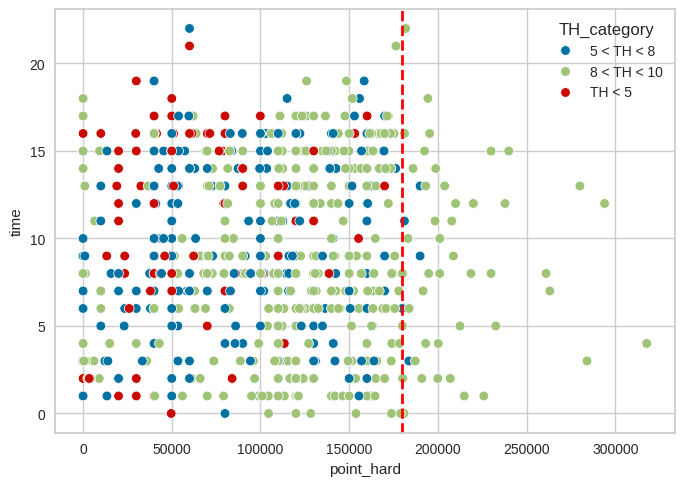

In [21]:
draw_scatter_plot('point_hard', 'time', x_threshold=180000)

### count problem vs avg submit

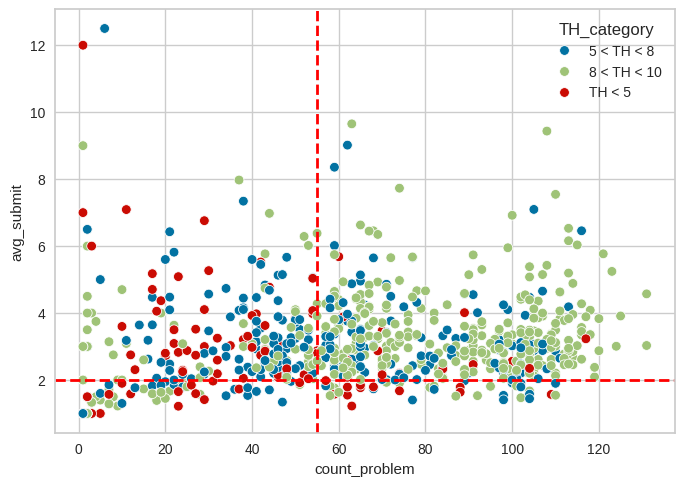

In [ ]:
draw_scatter_plot('count_problem', 'avg_submit', x_threshold=55, y_threshold=2)

### count_problem vs avg_coef

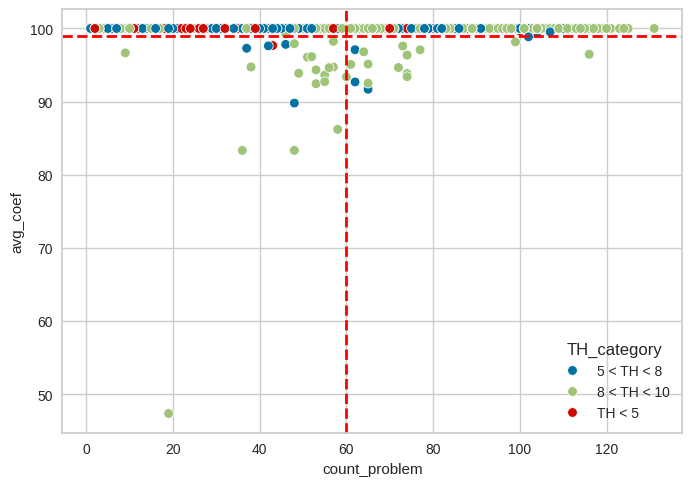

In [22]:
draw_scatter_plot('count_problem', 'avg_coef', x_threshold=60, y_threshold=99)

### count problem

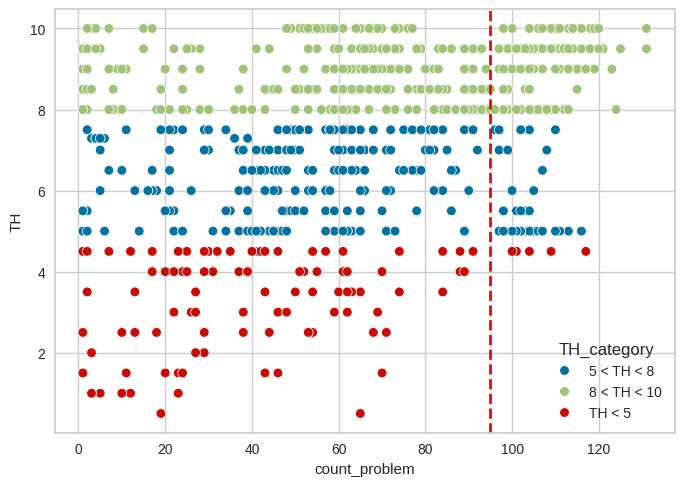

In [23]:
draw_scatter_plot('count_problem', 'TH', x_threshold=95)

### count assignment

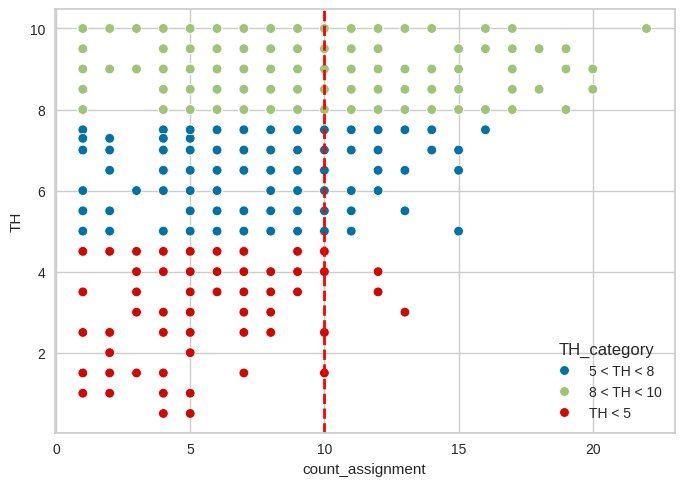

In [24]:
draw_scatter_plot('count_assignment', 'TH', x_threshold=10)

### max problem

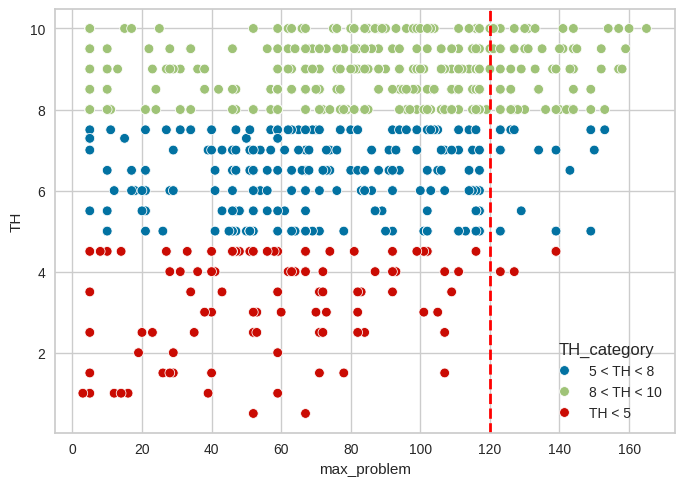

In [25]:
draw_scatter_plot('max_problem', 'TH', x_threshold=120)

### count hard problem

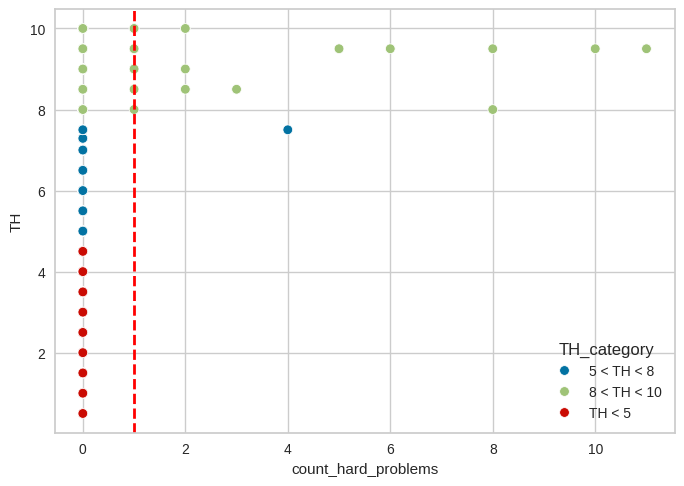

In [26]:
draw_scatter_plot('count_hard_problems', 'TH', x_threshold=1)

### point_hard/avg_submit vs count_submit

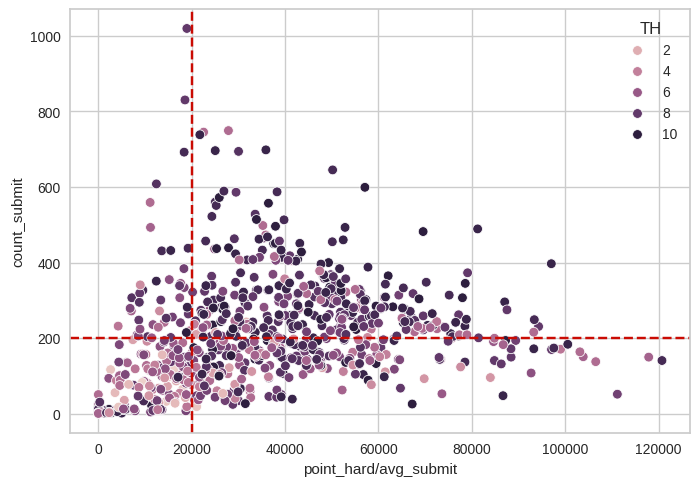

In [28]:
sns.scatterplot(x=th_df.point_hard/th_df.avg_submit, y=th_df.count_submit, hue=th_df.TH)
plt.xlabel('point_hard/avg_submit')
plt.axvline(x=20000, color='r', linestyle='--')
plt.axhline(y=200, color='r', linestyle='--')

## Feature engineering

In [15]:
def th_preprocess(df):
    df_copy = df.copy()
    df_copy['over_180000_point_hard'] = df_copy['point_hard'] > 180000
    df_copy['count_problem_over_55_avg_submit_over_2'] = np.where(
    (df_copy['count_problem'] > 55) & (df_copy['avg_submit'] > 2), 1, 0
    )
    df_copy['count_problem_over_60_avg_coef_over_90'] = np.where(
    (df_copy['count_problem'] > 60) & (df_copy['avg_coef'] >= 90), 1, 0
    )
    df_copy['over_85_problem'] = df_copy['count_problem'].apply(lambda x: 1 if x > 85 else 0)
    df_copy['over_10_assignment'] = df_copy['count_problem'].apply(lambda x: 1 if x > 10 else 0)
    df_copy['over_120_max_problem'] = df_copy['max_problem'].apply(lambda x: 1 if x > 120 else 0)
    df_copy['did_hard_problem'] = df_copy['count_hard_problems'].apply(lambda x: 1 if x > 0 else 0)
    df_copy['under_20000_point_hard/avg_submit_under_200_submit'] = np.where(
    (df_copy['point_hard']/df_copy['avg_submit'] < 20000) & (df_copy['count_submit'] < 200), 1, 0
    )
    return df_copy

In [16]:
if 'TH_category' in th_df.columns:
    th_df.drop(columns=['TH_category'], inplace=True)

In [17]:
train_df = th_preprocess(th_df)

In [18]:
len(th_df.columns), len(train_df.columns)

(18, 26)

### second experiment

In [21]:
s = setup(data = train_df.drop(columns=['username']), target = 'TH', use_gpu=True, profile=False, session_id=seed)
clear_output()
best_model = compare_models(fold=5, sort='R2')

Initiated  . . . . . . . . . . . . . . . . . .              13:56:59
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

In [20]:
second_expe = experiment(train_df, dev=True)
second_expe

Model      R2               Scaler
0       CatBoost Regressor  0.3039       StandardScaler
1       CatBoost Regressor  0.3037         MinMaxScaler
2       CatBoost Regressor  0.3057         RobustScaler
3  Random Forest Regressor  0.3226           Normalizer
4       CatBoost Regressor  0.3039         MaxAbsScaler
5           Bayesian Ridge  0.3186  QuantileTransformer
6           Bayesian Ridge  0.3140     PowerTransformer

## Feature selection

In [22]:
selector = RFECV(estimator=CatBoostRegressor(random_seed=seed, verbose=False),
                 cv=5, scoring='r2', n_jobs=-1)

In [23]:
selector.fit(train_df.drop(columns=['TH', 'username']), train_df['TH'])

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7a644c581690>,
      n_jobs=-1, scoring='r2')

In [24]:
np.save('./Data/th_selector_support.npy', selector.support_)

In [19]:
selector_support = np.load('./Data/th_selector_support.npy')

In [20]:
selected_features = train_df.drop(columns=['TH', 'username']).columns[selector_support]

In [21]:
df_train = train_df[['username', 'TH'] + list(selected_features)]

## pipeline

### preprocessing

In [22]:
def th_preprocessing(df_train, df_test):
    
    train = th_preprocess(df_train)
    test = th_preprocess(df_test)
    
    selector_support = np.load('./Data/th_selector_support.npy')
    train = train[['username', 'TH'] + list(train.drop(columns=['TH', 'username']).columns[selector_support])]
    test = test[['username'] + list(test.drop(columns=['username']).columns[selector_support])]
    
    scaler = Normalizer()
    features = train.drop(columns=['username', 'TH']).columns
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])
    
    return train, test

In [23]:
test = pd.read_csv('./Data/work_data.csv')
test = test[~test.username.isin(th_df.username)]

In [24]:
df_train, df_test = th_preprocessing(th_df, test)

## modelling

In [25]:
s = setup(data = df_train.drop(columns=['username']), target = 'TH', use_gpu=True, profile=False, session_id=seed)
clear_output()
top5 = compare_models(fold=5, sort='R2', n_select=5)

### hypertune

In [26]:
tuned_top5 = [tune_model(model, fold=5, n_iter=100, 
                         optimize='MAE', search_library='optuna', choose_better=True) for model in top5]

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.7825125376261814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7825125376261814
[LightGBM] [Warning] bagging_fraction is set=0.7453617362518203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7453617362518203
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.7825125376261814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7825125376261814
[LightGBM] [Warning] bagging_fraction is set=0.7453617362518203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7453617362518203
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 425, number of used features: 18
[LightGBM] [I

In [27]:
blender = blend_models(estimator_list=tuned_top5, fold=5)

In [28]:
stacker = stack_models(estimator_list=tuned_top5, fold=5)

### save load model

In [29]:
save_model(stacker, './model/TH/stacker')
save_model(blender, './model/TH/blender')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['count_submit', 'count_problem',
                                              'avg_submit', 'count_assignment',
                                              'sum_pre_score', 'avg_pre_score',
                                              'avg_coef', 'time', 'ratio',
                                              'point_hard', 'time_hard',
                                              'avg_submit_hard', 'start',
                                              'max_problem',
                                              'count_hard_problems',
                                              'ratio_problem',
                                              'count_problem_over_55_avg_submi...
                                              ('Light Gradient Boosting Machine',
                                               LGBMRegressor(bagging_fraction=0.765597249623235,
      

In [30]:
stacker = load_model('./model/TH/stacker')
blender = load_model('./model/TH/blender')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [31]:
from sklearn import set_config
set_config(display='diagram')
stacker

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['count_submit', 'count_problem',
                                             'avg_submit', 'count_assignment',
                                             'sum_pre_score', 'avg_pre_score',
                                             'avg_coef', 'time', 'ratio',
                                             'point_hard', 'time_hard',
                                             'avg_submit_hard', 'start',
                                             'max_problem',
                                             'count_hard_problems',
                                             'ratio_problem',
                                             'count_problem_over_5...
                                                LGBMRegressor(bagging_fraction=0.765597249623235,
                                                              bagging_freq=7,
                                                              device='gpu',
                                                              feature_fraction=0.4479273773932565,
                                                              learning_rate=0.01883589821811197,
                                                              min_child_samples=2,
                                                              min_split_gain=0.8815665305200342,
                                                              n_estimators=261,
                                                              n_jobs=-1,
                                                              num_leaves=121,
                                                              random_state=17,
                                                              reg_alpha=6.408115059514302e-09,
                                                              reg_lambda=7.748123848917015e-06))],
                                   final_estimator=LinearRegression(n_jobs=-1),
                                   n_jobs=1))])

In [32]:
blender

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['count_submit', 'count_problem',
                                             'avg_submit', 'count_assignment',
                                             'sum_pre_score', 'avg_pre_score',
                                             'avg_coef', 'time', 'ratio',
                                             'point_hard', 'time_hard',
                                             'avg_submit_hard', 'start',
                                             'max_problem',
                                             'count_hard_problems',
                                             'ratio_problem',
                                             'count_problem_over_5...
                                             ('Light Gradient Boosting Machine',
                                              LGBMRegressor(bagging_fraction=0.765597249623235,
                                                            bagging_freq=7,
                                                            device='gpu',
                                                            feature_fraction=0.4479273773932565,
                                                            learning_rate=0.01883589821811197,
                                                            min_child_samples=2,
                                                            min_split_gain=0.8815665305200342,
                                                            n_estimators=261,
                                                            n_jobs=-1,
                                                            num_leaves=121,
                                                            random_state=17,
                                                            reg_alpha=6.408115059514302e-09,
                                                            reg_lambda=7.748123848917015e-06))],
                                 n_jobs=1))])

### predict

In [36]:
predict = predict_model(stacker, data=df_test.drop(columns=['username']))

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4479273773932565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4479273773932565
[LightGBM] [Warning] bagging_fraction is set=0.765597249623235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765597249623235


In [37]:
submit = pd.DataFrame({'username': test.username, 'TH': predict.prediction_label})
submit.to_csv('./th_submit.csv', index=False, header=False)